# 05. Hex-grid correlations, Denmark-wide
## Project: Bicycle node network loop analysis

This notebook puts loop census and scenario data from 02 and 04 into an H3 grid and performs local spatial autocorrelation and pairwise correlations.  
Please select `denmark` as the `study_area` in the `config.yml`.

Contact: Michael Szell (michael.szell@gmail.com)

Created: 2025-08-01  
Last modified: 2025-08-25

## Parameters

In [1]:
%run -i setup_parameters.py
load_data = True  # Set to False if data are huge and have already been loaded
debug = False  # Set to True for extra plots and verbosity
plt.style.use(PATH["parameters"] + "plotstyle.mplstyle")

In [2]:
try:  # See if allloops_dict exists. If not, initialize. This allows running multiple scenarios.
    allloops_dict
except NameError:
    allloops_dict = {}
    dfunified_scenarios = {}
allloops_dict[SCENARIOID] = {}

In [3]:
print("Running scenario " + str(SCENARIOID) + " in " + STUDY_AREA)
for k, v in SCENARIO[SCENARIOID].items():
    print(k + ": " + str(v))

Running scenario 2 in bornholm
name: Family with e-bikes
name_short: Family e-bikes
maxslope_limit: 100
looplength_min: 10000
looplength_max: 40000


## Functions

In [4]:
%run -i functions.py

## Load data

This can take several minutes.

In [5]:
if load_data:
    if LOOP_LENGTH_BOUND:
        llb_string = "_maxlength" + str(LOOP_LENGTH_BOUND)
    else:
        llb_string = ""

    with open(
        PATH["data_out"]
        + "loopcensus_"
        + str(LOOP_NUMNODE_BOUND)
        + llb_string
        + ".pkl",
        "rb",
    ) as f:
        allloops = pickle.load(f)
        alllooplengths = pickle.load(f)
        allloopnumnodes = pickle.load(f)
        allloopmaxslopes = pickle.load(f)
        Gnx = pickle.load(f)
        LOOP_NUMNODE_BOUND = pickle.load(f)
        nodes_id = pickle.load(f)
        nodes_coords = pickle.load(f)
        #numloops = pickle.load(f)
        faceloops = pickle.load(f)

In [6]:
# Create gdf and igraph versions
nodes, edges = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)
nodes.set_crs(epsg=25832, inplace=True)
edges.set_crs(epsg=25832, inplace=True)
G = ig.Graph.from_networkx(Gnx)
G.summary()

/var/folders/q4/95x26cls17s1z694v56lw3hh0000gn/T/ipykernel_65728/2016841983.py:2: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)


'IGRAPH UNW- 59 89 -- \n+ attr: _nx_name (v), name (v), nodeID (v), x (v), y (v), edge_id (e), geometry (e), has_attraction (e), has_facility (e), has_service (e), has_water (e), max_slope (e), node_end (e), node_start (e), poi_diversity (e), weight (e)'

In [7]:
# Plot network
if debug:
    plot_dk_gdf(
        nodes,
        edges,
        scale=0.4,
        vertex_size=get_vertex_size_constant(G.vcount()),
        link_width=get_edgewidth_constant(G.ecount()),
    )

## Put into H3 grid

### Node density

In [8]:
if debug:
    nodes.plot.scatter(x="x", y="y", style=".", alpha=0.5, figsize=(5, 5))

In [9]:
nodes_nodata = nodes.drop(
    columns=["name", "_igraph_index", "x", "y", "nodeID"]
)  # drop all data
nodes_nodata.to_crs(epsg=4326, inplace=True)  # reproject for H3
if debug:
    print(nodes_nodata.head())

In [10]:
nodesh3 = nodes_nodata.assign(count=1).h3.geo_to_h3_aggregate(6)
if debug:
    print(nodesh3.head())

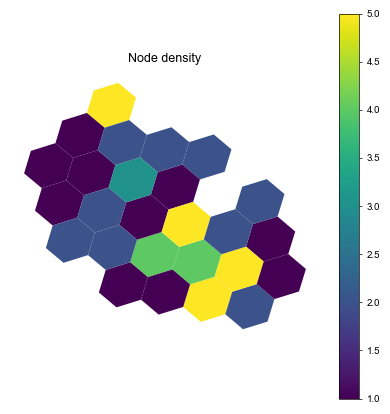

In [11]:
nodesh3.plot(column="count", figsize=(5, 5), legend=True)
plt.title("Node density")
plt.gca().axis("off");

### Edge properties

In [12]:
edgesh3 = edges.to_crs(epsg=25832)  # do geometric operations on projected CRS
edgesh3["geometry"] = edgesh3.geometry.centroid
edgesh3.to_crs(epsg=4326, inplace=True)  # project back for H3
if debug:
    print(edgesh3.head())

In [13]:
edges_length = edgesh3[["weight", "geometry"]]
edges_max_slope = edgesh3[["weight", "max_slope", "geometry"]].copy()
edges_has_water = edgesh3[["weight", "has_water", "geometry"]].copy()
edges_has_water["has_water"] = edges_has_water["has_water"].astype(
    int
)  # Turn True/False into 1/0
edges_poi_diversity = edgesh3[["weight", "poi_diversity", "geometry"]]

Weighted means (by length):

In [14]:
# https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe
wm = {
    "max_slope": lambda x: np.average(x, weights=edges_max_slope.loc[x.index, "weight"])
}
edges_max_slope_wmh3 = edges_max_slope.h3.geo_to_h3_aggregate(6, wm)

wm = {
    "has_water": lambda x: np.average(x, weights=edges_has_water.loc[x.index, "weight"])
}
edges_has_water_wmh3 = edges_has_water.h3.geo_to_h3_aggregate(6, wm)

wm = {
    "poi_diversity": lambda x: np.average(
        x, weights=edges_poi_diversity.loc[x.index, "weight"]
    )
}
edges_poi_diversity_wmh3 = edges_poi_diversity.h3.geo_to_h3_aggregate(6, wm)

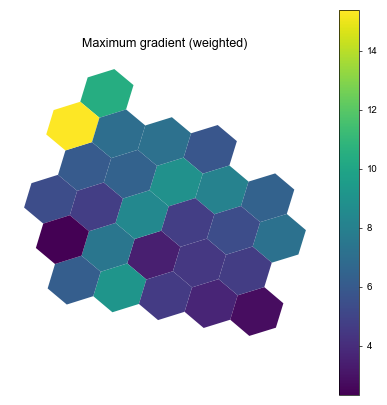

In [15]:
edges_max_slope_wmh3.plot(column="max_slope", figsize=(5, 5), legend=True)
plt.title("Maximum gradient (weighted)")
plt.gca().axis("off");

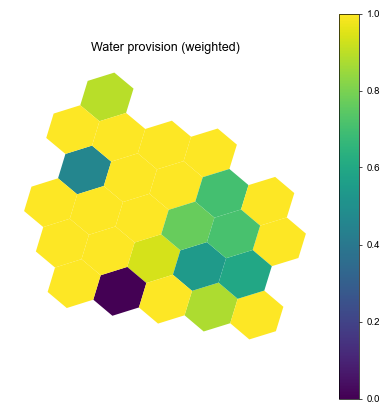

In [16]:
edges_has_water_wmh3.plot(column="has_water", figsize=(5, 5), legend=True)
plt.title("Water provision (weighted)")
plt.gca().axis("off");

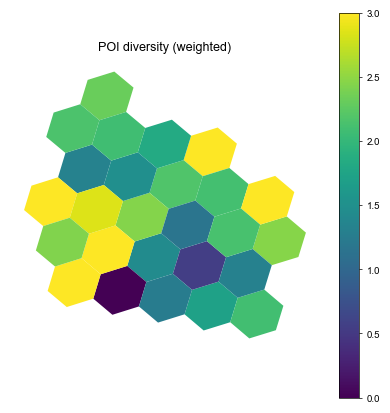

In [17]:
edges_poi_diversity_wmh3.plot(column="poi_diversity", figsize=(5, 5), legend=True)
plt.title("POI diversity (weighted)")
plt.gca().axis("off");

Unweighted means:

In [18]:
edges_lengthh3 = edges_length.h3.geo_to_h3_aggregate(6, "mean")
edges_max_slopeh3 = edges_max_slope.h3.geo_to_h3_aggregate(
    6, "mean"
)  # not weighted by length
edges_has_waterh3 = edges_has_water.h3.geo_to_h3_aggregate(
    6, "mean"
)  # not weighted by length
edges_poi_diversityh3 = edges_poi_diversity.h3.geo_to_h3_aggregate(
    6, "mean"
)  # not weighted by length

## LISA

### Node density

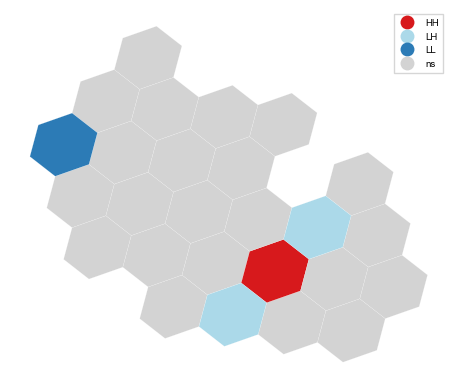

In [19]:
nodesh3.to_crs(epsg=25832, inplace=True)
w = weights.contiguity.Queen.from_dataframe(nodesh3, use_index=False)
if debug:
    plot_spatial_weights(w, nodesh3)
lisa = esda.Moran_Local(nodesh3["count"], w)
if debug:
    plot_local_autocorrelation(lisa, nodesh3, "count")
lisa_cluster(lisa, nodesh3, p=0.05)
nodesh3.to_crs(epsg=4326, inplace=True)

### Maximum gradient

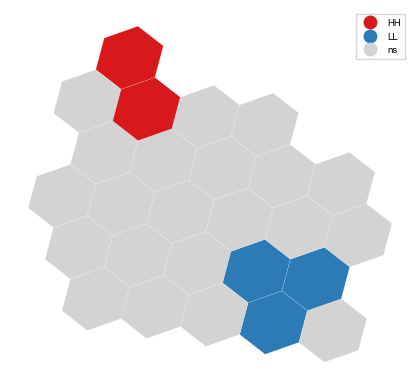

In [20]:
edges_max_slope_wmh3.to_crs(epsg=25832, inplace=True)
w = weights.contiguity.Queen.from_dataframe(edges_max_slope_wmh3, use_index=False)
if debug:
    plot_spatial_weights(w, edges_max_slope_wmh3)
lisa = esda.Moran_Local(edges_max_slope_wmh3["max_slope"], w)
if debug:
    plot_local_autocorrelation(lisa, edges_max_slope_wmh3, "max_slope")
lisa_cluster(lisa, edges_max_slope_wmh3, p=0.05)
edges_max_slope_wmh3.to_crs(epsg=4326, inplace=True)

### Water

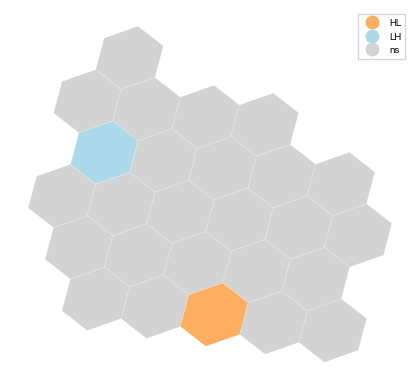

In [21]:
edges_has_water_wmh3.to_crs(epsg=25832, inplace=True)
w = weights.contiguity.Queen.from_dataframe(edges_has_water_wmh3, use_index=False)
if debug:
    plot_spatial_weights(w, edges_has_water_wmh3)
lisa = esda.Moran_Local(edges_has_water_wmh3["has_water"], w)
if debug:
    plot_local_autocorrelation(lisa, edges_has_water_wmh3, "has_water")
lisa_cluster(lisa, edges_has_water_wmh3, p=0.05)
edges_has_water_wmh3.to_crs(epsg=4326, inplace=True)

### POI diversity

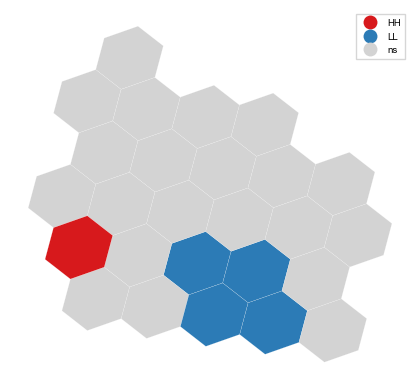

In [22]:
edges_poi_diversity_wmh3.to_crs(epsg=25832, inplace=True)
w = weights.contiguity.Queen.from_dataframe(edges_poi_diversity_wmh3, use_index=False)
if debug:
    plot_spatial_weights(w, edges_poi_diversity_wmh3)
lisa = esda.Moran_Local(edges_poi_diversity_wmh3["poi_diversity"], w)
if debug:
    plot_local_autocorrelation(lisa, edges_poi_diversity_wmh3, "poi_diversity")
lisa_cluster(lisa, edges_poi_diversity_wmh3, p=0.05)
edges_poi_diversity_wmh3.to_crs(epsg=4326, inplace=True)

### Plot all in one

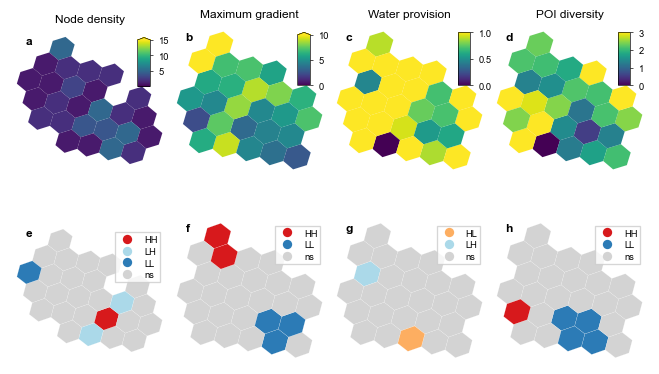

In [23]:
plotinfo = [
    {
        "title": "Node density",
        "data": nodesh3,
        "column": "count",
        "ticks": [5, 10, 15],
        "extend": "max",
        "vmax": 15,
        "subplotlabel": "a",
    },
    {
        "title": "Maximum gradient",
        "data": edges_max_slope_wmh3,
        "column": "max_slope",
        "ticks": [0, 5, 10],
        "extend": "max",
        "vmax": 10,
        "subplotlabel": "b",
    },
    {
        "title": "Water provision",
        "data": edges_has_water_wmh3,
        "column": "has_water",
        "ticks": [0, 0.5, 1],
        "extend": "neither",
        "vmax": False,
        "subplotlabel": "c",
    },
    {
        "title": "POI diversity",
        "data": edges_poi_diversity_wmh3,
        "column": "poi_diversity",
        "ticks": [0, 1, 2, 3],
        "extend": "neither",
        "vmax": False,
        "subplotlabel": "d",
    },
    {
        "data": nodesh3,
        "column": "count",
        "subplotlabel": "e",
    },
    {
        "data": edges_max_slope_wmh3,
        "column": "max_slope",
        "subplotlabel": "f",
    },
    {
        "data": edges_has_water_wmh3,
        "column": "has_water",
        "subplotlabel": "g",
    },
    {
        "data": edges_poi_diversity_wmh3,
        "column": "poi_diversity",
        "subplotlabel": "h",
    },
]

fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    figsize=(640 / PLOTPARAM["dpi"], 400 / PLOTPARAM["dpi"]),
    dpi=PLOTPARAM["dpi"],
    squeeze=True,
)

for i, ax in enumerate(axes[0]):  # First row: choropleth maps
    if plotinfo[i]["vmax"]:
        vmin, vmax = 0, plotinfo[i]["vmax"]
    else:
        vmin, vmax = 0, plotinfo[i]["data"][plotinfo[i]["column"]].max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    # https://stackoverflow.com/questions/40982050/how-to-cut-the-unwanted-part-of-a-colorbar
    # Generate colors from original colormap in the range equivalent to [vmin, vamx]
    cmap = plt.get_cmap("viridis")
    colors = cmap(np.linspace(1.0 - (vmax - vmin) / float(vmax), 1, cmap.N))
    # Create a new colormap from those colors
    color_map = mpl.colors.LinearSegmentedColormap.from_list("viridis", colors)

    cax = ax.inset_axes([0.8, 0.6, 0.08, 0.35])
    # https://matplotlib.org/stable/users/explain/axes/colorbar_placement.html#manual-placement-of-colorbars
    plotinfo[i]["data"].plot(
        column=plotinfo[i]["column"],
        linewidth=0.01,
        edgecolor="face",  # https://stackoverflow.com/questions/55759070/geopandas-mapplotlib-how-do-i-plot-without-an-outline-around-any-shape
        legend=True,
        legend_kwds={
            "ticks": plotinfo[i]["ticks"],
            "cmap": color_map,
            "norm": norm,
            "extend": plotinfo[i]["extend"],
        },
        cax=cax,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
    )
    if plotinfo[i]["title"] == "Maximum gradient":
        cax.set_ylim([0, 10])
    ax.set_axis_off()
    ax.title.set_text(plotinfo[i]["title"])
    ax.text(
        0.1,
        0.9,
        plotinfo[i]["subplotlabel"],
        weight="bold",
        size=9,
        transform=ax.transAxes,
    )
for i, ax in enumerate(axes[1]):  # Second row: LISAs
    data = plotinfo[i + 4]["data"]
    data.to_crs(epsg=25832, inplace=True)
    w = weights.contiguity.Queen.from_dataframe(data, use_index=False)
    lisa = esda.Moran_Local(data[plotinfo[i + 4]["column"]], w)
    lisa_cluster(
        lisa,
        data,
        p=0.05,
        ax=ax,
        legend_kwds={
            "markerscale": 0.7,
            "labelspacing": 0.3,
            "borderpad": 0.3,
            "borderaxespad": 1.0,
        },
    )
    ax.text(
        0.1,
        0.9,
        plotinfo[i + 4]["subplotlabel"],
        weight="bold",
        size=9,
        transform=ax.transAxes,
    )

plt.subplots_adjust(top=0.95, bottom=0, left=0, right=1, wspace=0, hspace=0)
fig.savefig(PATH["plot"] + "h3.pdf", facecolor="white", edgecolor="none")

## Loop census

### Restrict to scenario lengths

In [24]:
allloops_dict[SCENARIOID][0] = restrict_scenario(allloops, allloops, level=0)

Restrict to scenario lengths:   0%|          | 0/59 [00:00<?, ?it/s]

In [25]:
nodes_loopnum1 = nodes.drop(
    columns=["name", "_igraph_index", "x", "y", "nodeID"]
)  # drop all data
nodes_loopnum1.to_crs(epsg=4326, inplace=True)  # reproject for H3
nodes_loopnum1["loopnum1"] = get_vertex_loopnums(
    allloops_dict[SCENARIOID][0], "log2"
).tolist()
if debug:
    print(nodes_loopnum1.head())

In [26]:
nodes_loopnum1h3 = nodes_loopnum1.h3.geo_to_h3_aggregate(6, "mean")
if debug:
    print(nodes_loopnum1h3.head())

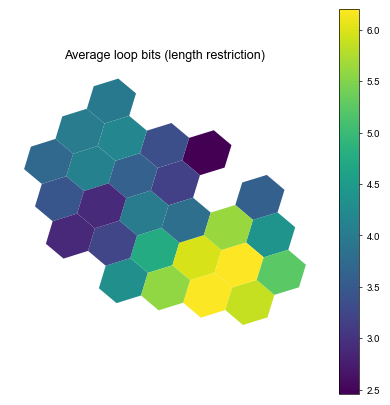

In [27]:
nodes_loopnum1h3.plot(column="loopnum1", figsize=(5, 5), legend=True)
plt.title("Average loop bits (length restriction)")
plt.gca().axis("off");

### Restrict to scenario gradients

In [28]:
allloops_dict[SCENARIOID][1] = restrict_scenario(
    allloops, allloops_dict[SCENARIOID][0], level=1
)

Restrict to scenario gradients:   0%|          | 0/59 [00:00<?, ?it/s]

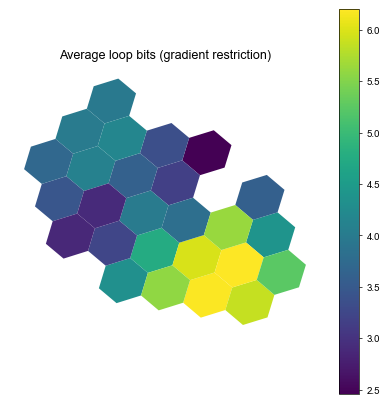

In [29]:
nodes_loopnum2 = nodes.drop(
    columns=["name", "_igraph_index", "x", "y", "nodeID"]
)  # drop all data
nodes_loopnum2.to_crs(epsg=4326, inplace=True)  # reproject for H3
nodes_loopnum2["loopnum2"] = get_vertex_loopnums(
    allloops_dict[SCENARIOID][1], "log2"
).tolist()
if debug:
    print(nodes_loopnum2.head())

nodes_loopnum2h3 = nodes_loopnum2.h3.geo_to_h3_aggregate(6, "mean")
nodes_loopnum2h3.plot(column="loopnum2", figsize=(5, 5), legend=True)
plt.title("Average loop bits (gradient restriction)")
plt.gca().axis("off");

### Restrict to water limits

In [30]:
allloops_dict[SCENARIOID][2] = restrict_scenario(
    allloops, allloops_dict[SCENARIOID][1], level=2
)

Restrict to water limits:   0%|          | 0/59 [00:00<?, ?it/s]

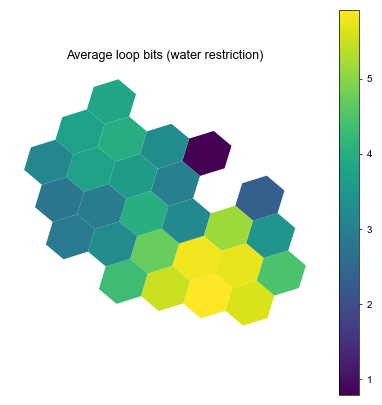

In [31]:
nodes_loopnum3 = nodes.drop(
    columns=["name", "_igraph_index", "x", "y", "nodeID"]
)  # drop all data
nodes_loopnum3.to_crs(epsg=4326, inplace=True)  # reproject for H3
nodes_loopnum3["loopnum3"] = get_vertex_loopnums(
    allloops_dict[SCENARIOID][2], "log2"
).tolist()
if debug:
    print(nodes_loopnum3.head())

nodes_loopnum3h3 = nodes_loopnum3.h3.geo_to_h3_aggregate(6, "mean")
nodes_loopnum3h3.plot(column="loopnum3", figsize=(5, 5), legend=True)
plt.title("Average loop bits (water restriction)")
plt.gca().axis("off");

### Restrict with POI diversity

In [32]:
allloops_dict[SCENARIOID][3] = restrict_scenario(
    allloops, allloops_dict[SCENARIOID][2], level=3
)

Restrict with POI diversity:   0%|          | 0/59 [00:00<?, ?it/s]

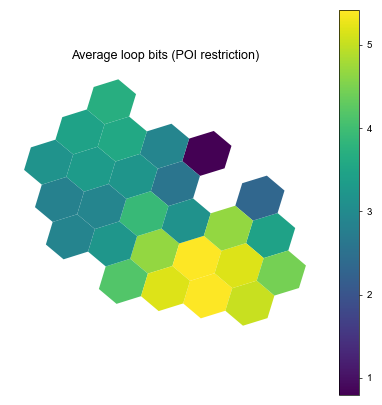

In [33]:
nodes_loopnum4 = nodes.drop(
    columns=["name", "_igraph_index", "x", "y", "nodeID"]
)  # drop all data
nodes_loopnum4.to_crs(epsg=4326, inplace=True)  # reproject for H3
nodes_loopnum4["loopnum4"] = get_vertex_loopnums(
    allloops_dict[SCENARIOID][3], "log2"
).tolist()
if debug:
    print(nodes_loopnum4.head())

nodes_loopnum4h3 = nodes_loopnum4.h3.geo_to_h3_aggregate(6, "mean")
nodes_loopnum4h3.plot(column="loopnum4", figsize=(5, 5), legend=True)
plt.title("Average loop bits (POI restriction)")
plt.gca().axis("off");

## Correlate

### Scenarios

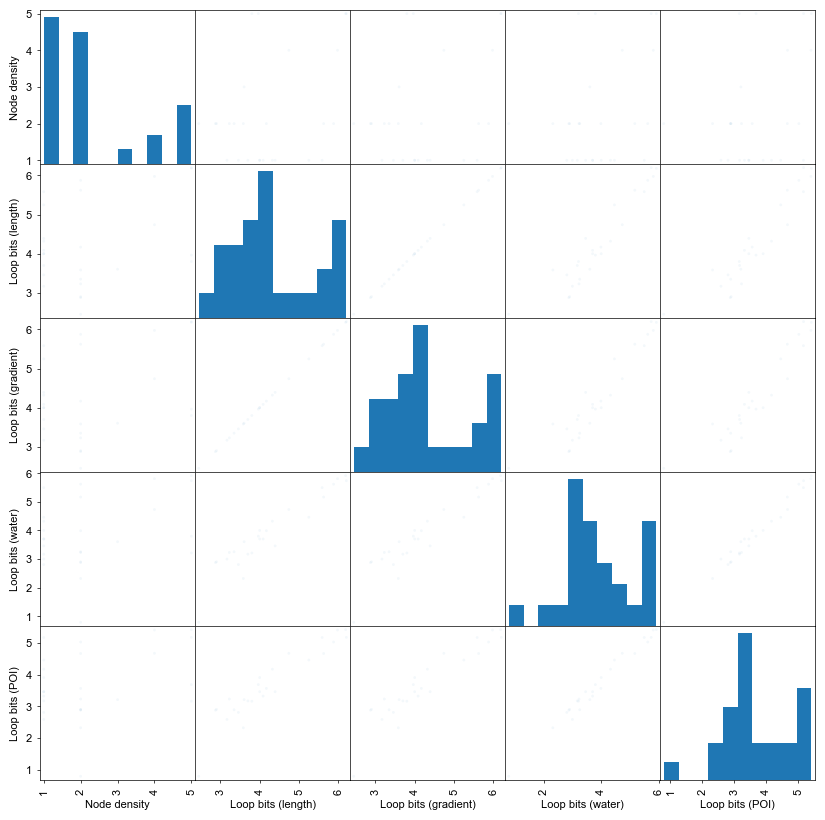

In [34]:
dfunified_scenarios[SCENARIOID] = (
    nodesh3.join(nodes_loopnum1h3.drop(columns="geometry"))
    .join(nodes_loopnum2h3.drop(columns="geometry"))
    .join(nodes_loopnum3h3.drop(columns="geometry"))
    .join(nodes_loopnum4h3.drop(columns="geometry"))
    .rename(
        columns={
            "count": "Node density",
            "loopnum1": "Loop bits (length)",
            "loopnum2": "Loop bits (gradient)",
            "loopnum3": "Loop bits (water)",
            "loopnum4": "Loop bits (POI)",
        }
    )
)

pd.plotting.scatter_matrix(
    dfunified_scenarios[SCENARIOID], alpha=0.05, figsize=(10, 10)
);

slope (95%): 0.455 +/- 0.524, r-value: 0.343, p-value: 0.08581547685056251
intercept (95%): 0.335 +/- 2.299
slope (95%): 0.455 +/- 0.524, r-value: 0.343, p-value: 0.08581547685056251
intercept (95%): 0.335 +/- 2.299
slope (95%): 0.406 +/- 0.470, r-value: 0.342, p-value: 0.08698886551582548
intercept (95%): 0.691 +/- 1.911
slope (95%): 0.444 +/- 0.525, r-value: 0.335, p-value: 0.09411913274219226
intercept (95%): 0.640 +/- 2.011


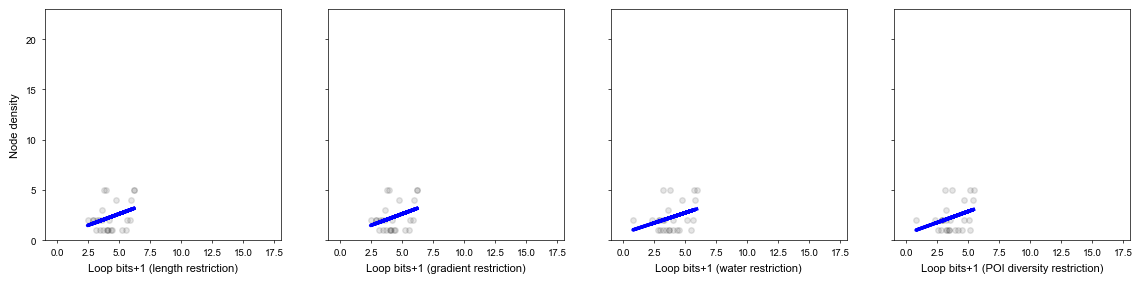

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 3))

xs = [
    dfunified_scenarios[SCENARIOID]["Loop bits (length)"],
    dfunified_scenarios[SCENARIOID]["Loop bits (gradient)"],
    dfunified_scenarios[SCENARIOID]["Loop bits (water)"],
    dfunified_scenarios[SCENARIOID]["Loop bits (POI)"],
]
xlabels = ["length", "gradient", "water", "POI diversity"]

for i in range(len(xs)):
    axes[i].scatter(xs[i], nodesh3["count"], color="k", alpha=0.1)

    res = scipy.stats.linregress(xs[i], nodesh3["count"])
    axes[i].plot(
        xs[i],
        res.slope * xs[i] + res.intercept,
        linewidth=2.5,
        color="b",
    )

    axes[i].set_xlabel(
        "Loop bits+1 (" + xlabels[i] + " restriction)"
    )  # +1 because of +1 in get_vertex_loopnums
    if i == 0:
        axes[i].set_ylabel("Node density")
    else:
        axes[i].set_yticklabels([])

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
    ts = tinv(0.05, len(xs[i]) - 2)
    print(
        f"slope (95%): {res.slope:.3f} +/- {ts*res.stderr:.3f}, r-value: {res.rvalue:.3f}, p-value: {res.pvalue}"
    )
    print(f"intercept (95%): {res.intercept:.3f}" f" +/- {ts*res.intercept_stderr:.3f}")

    # confband(xs[i], nodesh3["count"], axes[i]) # The confband doesn't add much value
    axes[i].set_ylim([0, 23])
    axes[i].set_xlim([-1, 18])

### Existing properties

#### Unweighted by length

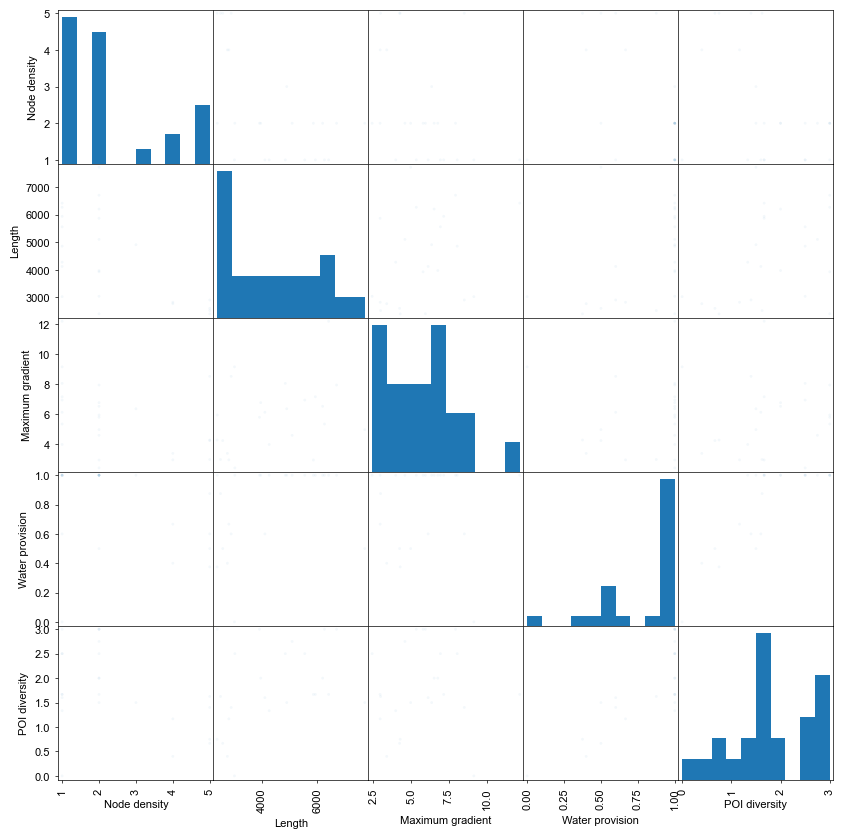

In [36]:
dfunified_properties = (
    nodesh3.join(edges_lengthh3.drop(columns=["geometry"]))
    .join(edges_max_slopeh3.drop(columns=["geometry", "weight"]))
    .join(edges_has_waterh3.drop(columns=["geometry", "weight"]))
    .join(edges_poi_diversityh3.drop(columns=["geometry", "weight"]))
    .rename(
        columns={
            "count": "Node density",
            "weight": "Length",
            "max_slope": "Maximum gradient",
            "has_water": "Water provision",
            "poi_diversity": "POI diversity",
        }
    )
)

pd.plotting.scatter_matrix(dfunified_properties, alpha=0.05, figsize=(10, 10));

#### Weighted by length

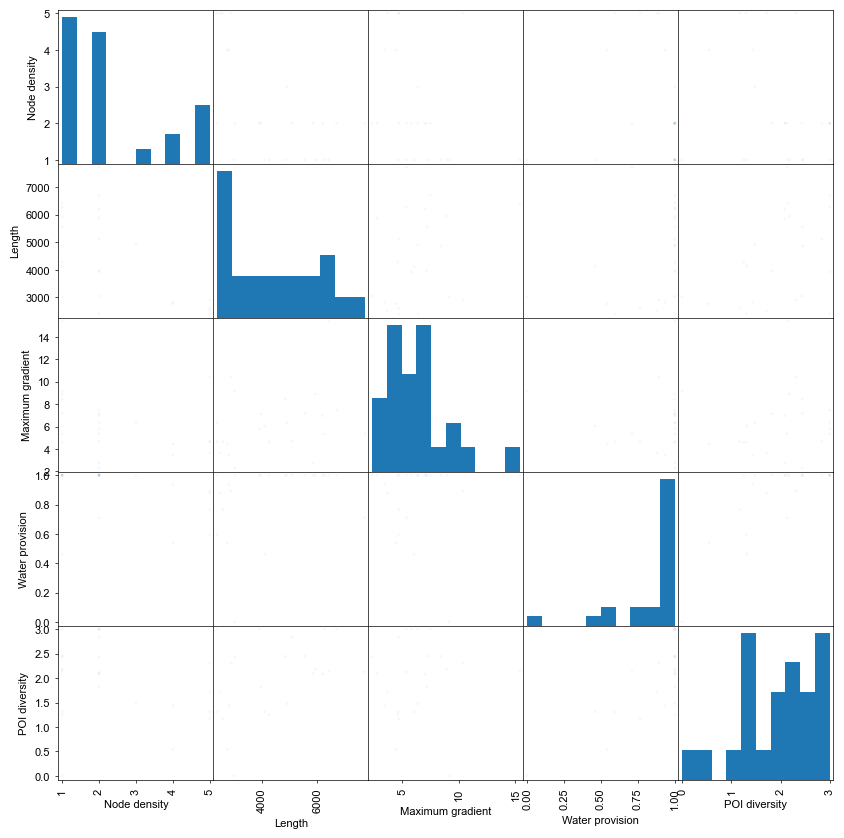

In [37]:
dfunified_properties_weighted = (
    nodesh3.join(edges_lengthh3.drop(columns="geometry"))
    .join(edges_max_slope_wmh3.drop(columns="geometry"))
    .join(edges_has_water_wmh3.drop(columns="geometry"))
    .join(edges_poi_diversity_wmh3.drop(columns="geometry"))
    .rename(
        columns={
            "count": "Node density",
            "weight": "Length",
            "max_slope": "Maximum gradient",
            "has_water": "Water provision",
            "poi_diversity": "POI diversity",
        }
    )
)

pd.plotting.scatter_matrix(dfunified_properties_weighted, alpha=0.05, figsize=(10, 10));

We care mostly about the first row. Visualize it better:

slope (95%): -0.163 +/- 0.219, r-value: -0.311, p-value: 0.1388186270514813
intercept (95%): 3.401 +/- 1.505
slope (95%): -0.640 +/- 2.602, r-value: -0.108, p-value: 0.6166765903275416
intercept (95%): 2.929 +/- 2.339
slope (95%): -0.521 +/- 0.782, r-value: -0.281, p-value: 0.18286785257442284
intercept (95%): 3.398 +/- 1.651


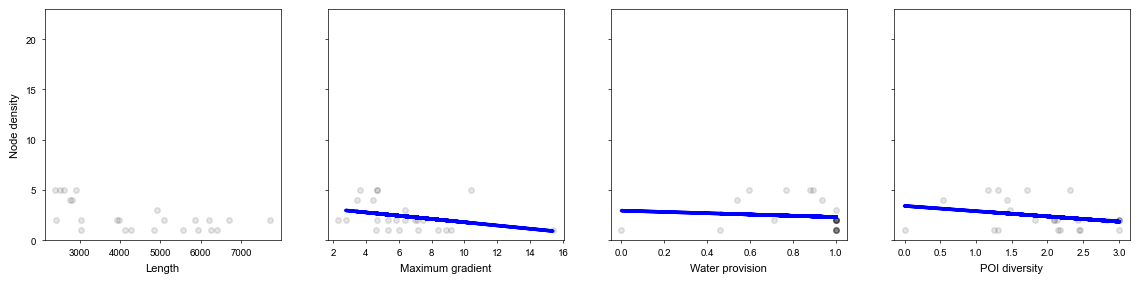

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 3))

y = nodesh3["count"].to_list()
xlabels = ["Length", "Maximum gradient", "Water provision", "POI diversity"]

nonnanmask = ~np.isnan(dfunified_properties_weighted[xlabels[3]].to_list())

for i in range(len(xlabels)):
    axes[i].scatter(
        dfunified_properties_weighted[xlabels[i]].to_list(), y, color="k", alpha=0.1
    )

    if i != 0:
        res = scipy.stats.linregress(
            np.array(dfunified_properties_weighted[xlabels[i]])[nonnanmask],
            np.array(y)[nonnanmask],
        )
        axes[i].plot(
            dfunified_properties_weighted[xlabels[i]],
            res.slope * dfunified_properties_weighted[xlabels[i]] + res.intercept,
            linewidth=2.5,
            color="b",
        )
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
        ts = tinv(0.05, len(np.array(y)[nonnanmask] - 2))
        print(
            f"slope (95%): {res.slope:.3f} +/- {ts*res.stderr:.3f}, r-value: {res.rvalue:.3f}, p-value: {res.pvalue}"
        )
        print(
            f"intercept (95%): {res.intercept:.3f}"
            f" +/- {ts*res.intercept_stderr:.3f}"
        )

    if i == 0:
        axes[i].set_ylabel("Node density")
    else:
        axes[i].set_yticklabels([])
    axes[i].set_xlabel(xlabels[i])
    axes[i].set_ylim([0, 23])

### Plot all correlations together

Run this notebook on all three scenarios to fully populate `dfunified_scenarios`.

In [39]:
try:
    plt.style.use(PATH["parameters"] + "plotstyle.mplstyle")
    dfunified_scenarios[0]
    dfunified_scenarios[1]
    dfunified_scenarios[2]

    fig, axrows = plt.subplots(
        nrows=4,
        ncols=4,
        figsize=(640 / PLOTPARAM["dpi"], 480 / PLOTPARAM["dpi"]),
        dpi=PLOTPARAM["dpi"],
        squeeze=True,
    )

    rownum = 0
    axes = axrows[rownum]
    y = nodesh3["count"].to_list()
    xlabels = ["Length", "Maximum gradient", "Water provision", "POI diversity"]

    nonnanmask = ~np.isnan(dfunified_properties_weighted[xlabels[3]].to_list())

    for i in range(len(xlabels)):
        axes[i].scatter(
            dfunified_properties_weighted[xlabels[i]].to_list(),
            y,
            color="k",
            alpha=0.1,
            linewidth=0,
        )

        if i != 0:
            res = scipy.stats.linregress(
                np.array(dfunified_properties_weighted[xlabels[i]])[nonnanmask],
                np.array(y)[nonnanmask],
            )
            axes[i].plot(
                dfunified_properties_weighted[xlabels[i]],
                res.slope * dfunified_properties_weighted[xlabels[i]] + res.intercept,
                linewidth=1.5,
                color="b",
            )
            if res.pvalue > 0.001:
                axes[i].text(
                    0.96,
                    0.95,
                    f"r = {res.rvalue:.2f}\np = {res.pvalue:.2f}",
                    horizontalalignment="right",
                    verticalalignment="top",
                    transform=axes[i].transAxes,
                )
            else:
                axes[i].text(
                    0.96,
                    0.95,
                    f"r = {res.rvalue:.2f}",
                    horizontalalignment="right",
                    verticalalignment="top",
                    transform=axes[i].transAxes,
                )

        if i == 0:
            axes[i].set_ylabel("Node density")
        else:
            axes[i].set_yticklabels([])
        axes[i].set_xlabel(xlabels[i])
        axes[i].set_ylim([0, 23])
        axes[i].set_yticks([0, 5, 10, 15, 20])
        if i == 1:  # max gradient has some outliers
            axes[i].set_xlim([0, 20])
        if i == 2:  # nicer xticks for water
            axes[i].set_xticks([0, 0.25, 0.5, 0.75, 1])

    for rownum in [1, 2, 3]:
        axes = axrows[rownum]
        sid = rownum - 1

        xs = [
            dfunified_scenarios[sid]["Loop bits (length)"],
            dfunified_scenarios[sid]["Loop bits (gradient)"],
            dfunified_scenarios[sid]["Loop bits (water)"],
            dfunified_scenarios[sid]["Loop bits (POI)"],
        ]
        xlabels = ["Length", "Gradient", "Water", "POI diversity"]

        for i in range(len(xs)):
            axes[i].scatter(xs[i], nodesh3["count"], color="k", alpha=0.1, linewidth=0)

            res = scipy.stats.linregress(xs[i], nodesh3["count"])
            axes[i].plot(
                xs[i],
                res.slope * xs[i] + res.intercept,
                linewidth=1.5,
                color="b",
            )

            if rownum == 3:
                axes[i].set_xlabel(
                    "Loop bits+1\n" + xlabels[i] + " restriction"
                )  # +1 because of +1 in get_vertex_loopnums
            if i == 0:
                axes[i].set_ylabel(SCENARIO[sid]["name_short"] + "\n\n Node density")
            else:
                axes[i].set_yticklabels([])
            if rownum == 1 or rownum == 2:
                axes[i].set_xticklabels([])
            axes[i].set_xticks([0, 4, 8, 12, 16])

            # confband(xs[i], nodesh3["count"], axes[i]) # The confband doesn't add much value
            axes[i].set_ylim([0, 23])
            axes[i].set_xlim([-1, 18])
            axes[i].set_yticks([0, 5, 10, 15, 20])
            if res.pvalue > 0.001:
                axes[i].text(
                    0.96,
                    0.95,
                    f"r = {res.rvalue:.2f}\np = {res.pvalue:.2f}",
                    horizontalalignment="right",
                    verticalalignment="top",
                    transform=axes[i].transAxes,
                )
            else:
                axes[i].text(
                    0.96,
                    0.95,
                    f"r = {res.rvalue:.2f}",
                    horizontalalignment="right",
                    verticalalignment="top",
                    transform=axes[i].transAxes,
                )

    plt.subplots_adjust(
        top=0.93, bottom=0.17, left=0.12, right=0.97, wspace=0.16, hspace=0.22
    )

    # Shift top row upwards
    axes = axrows[0]
    for i in range(len(xlabels)):
        l, b, w, h = axes[i].get_position().bounds
        axes[i].set_position([l, b + 0.25 * h, w, h])
        axes[i].get_position()
    # Shift bottom 3 rows downwards
    for rownum in [1, 2, 3]:
        axes = axrows[rownum]
        for i in range(len(xlabels)):
            l, b, w, h = axes[i].get_position().bounds
            axes[i].set_position([l, b - 0.25 * h, w, h])
            axes[i].get_position()

    fig.savefig(
        PATH["plot"] + "nodedensityscatter.pdf", facecolor="white", edgecolor="none"
    )

except KeyError:
    print("Please re-run this notebook for all scenarioids 0, 1 and 2")

Please re-run this notebook for all scenarioids 0, 1 and 2
